In [1]:
# Calculation for the tracer age
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import gsw

In [8]:
s_dep = 1
xi = np.array([1,260])
File01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/state_'+str(format(s_dep,'03d'))+'.nc')
File1 = File01.isel(T=~File01.get_index("T").duplicated())
File02 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/ptracers_'+str(format(s_dep,'03d'))+'.nc')
File2 = File02.isel(T=~File02.get_index("T").duplicated())
File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/grid_'+str(format(s_dep,'03d'))+'.nc')
state = File1.isel(X=range(xi[0],xi[1]), Y=range(35,45), Yp1=range(35,45))
ptracer = File2.isel(X=range(xi[0],xi[1]), Y=range(35,45))
grid = File3.isel(X=range(xi[0],xi[1]), Y=range(35,45), Yp1=range(35,45))
    
x_dist = state.X.data / 1000
time = state.T.data/86400

HFacC = grid.HFacC.data
drF = grid.drF.data
rA = grid.rA.data
cv = np.broadcast_to(rA[np.newaxis, :, :], HFacC.shape) * np.broadcast_to(drF[:, np.newaxis, np.newaxis], HFacC.shape) * HFacC

        
alpha = ptracer.tr1_rlx.data # Age concentration (linearly increasing tracer concentration)
C = ptracer.tr1_age.data # Total concentration (Constant tracer concentration)
    
    
NT, NZ, NY, NX = alpha.shape
    
age_dis = np.empty((NT,NZ*NY*NX))

t = -1
        
age = alpha[t,:,:,:] * 1000 / C[t,:,:,:] * time[t]

age_vol = age * cv * NZ * NX * NY / cv.sum()

age_vol[age_vol>time[t]] = time[t]

age_ma = age_vol[np.isfinite(age_vol)]

hist, edge = np.histogram(age.flatten(), bins=100, range=(0,60))


/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
dd = File1.Xp1.data / 1000
dd[120], dd[-1]-dd[121], dd

In [2]:
hs = np.array([1,3,5])

idx = 0
state_ini = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg500/state_' + str(format(hs[idx],'03d')) + '.nc')
ptracer_ini = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg500/ptracers_' + str(format(hs[idx],'03d')) + '.nc')
state = state_ini.isel(Y=range(30,39), Yp1=range(30,40))
ptracer = ptracer_ini.isel(Y=range(30,39))



x_dist = state.X.data / 1000
depth = state.Z.data
time = state.T.data / 86400
Uzx = (state.U.data[:,:,:,1:].mean(axis=(0,2))+state.U.data[:,:,:,:-1].mean(axis=(0,2)))/2

s = state.S.data.mean(2) # Salinity
pt = state.Temp.data.mean(2) # Potential temperature
pres = gsw.p_from_z(depth, 55)
p = np.tile(pres,[len(x_dist),1]).T

C = ptracer.tr1_age.data[:,:,0,:]
alpha = ptracer.tr1_rlx.data[:,:,0,:]


mask = (s == 0) # Exclude data covered by the sill
s[mask] = np.nan
pt[mask] = np.nan
C[mask] = np.nan
alpha[mask] = np.nan

#ptracer.T

In [ ]:
#x_dist
#time[-1]
import math
H = 150
Hs = 9
Xs = 5.8
L = 0.5

#bathy = np.empty(len(x_dist))
#for i in range(len(x_dist)):
bathy = -H+(H-Hs)*np.exp(-((x_dist-Xs)/L)**2/2)

bathy

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


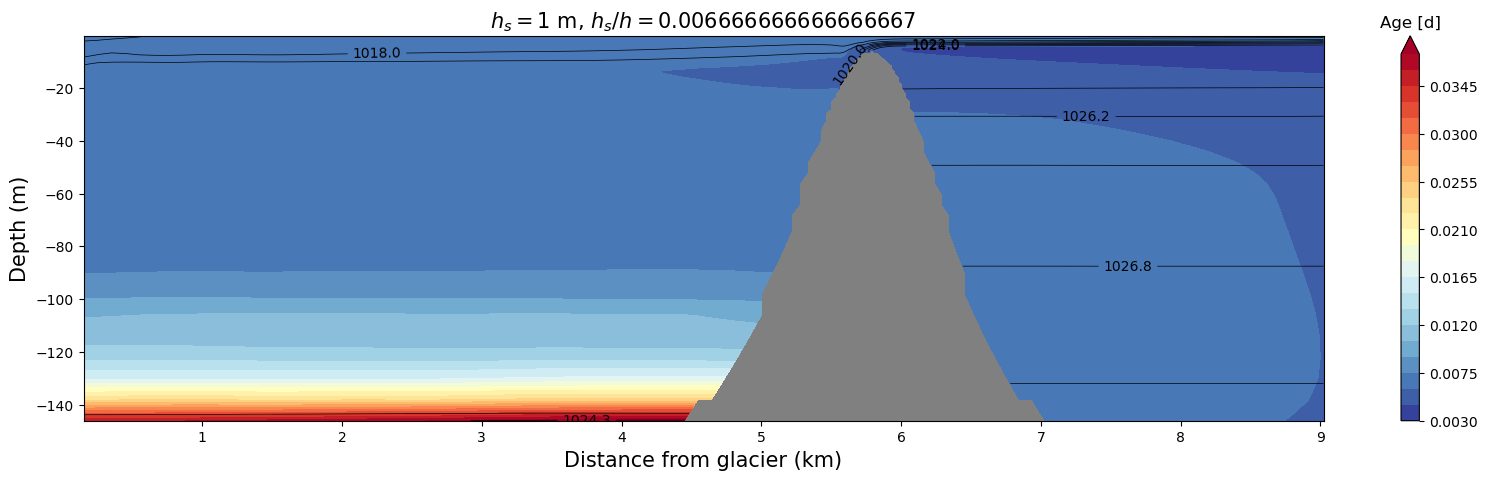

In [6]:
t_idx = -1 # times 6 hours
age = alpha / C * time[t_idx] 
#age[age>30] = 30

rho = gsw.rho(s[t_idx,:,:], pt[t_idx,:,:], p) # Density


xl, xr = 1, 120

# Contour plot of the age
#cm = np.linspace(0,15,30) # Contour range
cm = np.linspace(3,9,20) # Contour range
#cm = np.linspace(0,30,30) # Contour range
cs1 = np.linspace(1015,1024,10)
cs2 = np.linspace(1024,1030,20)

cmap = 'RdYlBu_r'
#cmap = 'RdYlGn_r'

fig1 = plt.figure(figsize=(20,5))
fig1.tight_layout()  
       
ax1 = fig1.add_subplot(111)
im1 = ax1.contourf(x_dist[xl:xr], depth, age[t_idx,:,xl:xr], 30, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax1.set_facecolor('grey')


#ax1.plot(x_dist[1:120],bathy[1:120],'k-',lw=2)

cbar1 = fig1.colorbar(im1)
#cbar1.set_ticks([3, 5, 7, 9])
#cbar1.set_ticks([0, .5, 1, 1.5])
#cbar1.set_ticks([0, .5, 1, 1.5, 2])
cbar1.ax.set_title(r'Age [d]', size=12)
#cbar1.ax.set_title(r'$C_A$', size=12)
CS1 = ax1.contour(x_dist[xl:xr], depth[:20], rho[:20,xl:xr], cs1, colors='black', linewidths=.5)
plt.clabel(CS1, cs1[1::2], fmt='%1.1f', fontsize=10, inline=True)


CS2 = ax1.contour(x_dist[xl:xr], depth[20:], rho[20:,xl:xr], cs2, colors='black', linewidths=.5)
plt.clabel(CS2, cs2[1::2], fmt='%1.1f', fontsize=10, inline=True)

ax1.set_ylabel('Depth (m)', size=15)
ax1.set_title(r'$h_s=$'+str(hs[idx])+' m, $h_s/h=$'+str(hs[idx]/150), loc='center', size=15)
ax1.set_xlabel('Distance from glacier (km)', size=15)
plt.show()

In [ ]:
#np.nanmax(age[:,xl:xr]), np.nanmin(age[:,xl:xr])
c1 = C[t_idx,:,xl:xr]
a1 = alpha[t_idx,:,xl:xr]
aa = c1 - a1

aa[:,4], c1[:,4], a1[:,4]

In [ ]:
def tracer_age(s_dep):
    
    File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/state_'+str(format(s_dep,'03d'))+'.nc')
    File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/ptracers_'+str(format(s_dep,'03d'))+'.nc')
    File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/grid_'+str(format(s_dep,'03d'))+'.nc')
    state = File1.isel(Y=range(30,39), Yp1=range(30,40))
    ptracer = File2.isel(Y=range(30,39))
    grid = File3.isel(Y=range(30,39), Yp1=range(30,40))
    
    s = state.S.data[-1,:,:,:]
    sma = np.ma.masked_where(s==0, s)
    topo = np.ma.getmask(sma) # Masked Topography
    
    
    
    #mask = (s == 0) # Exclude data covered by the sill
    
    HFacC = grid.HFacC.data
    drF = grid.drF.data
    rA = grid.rA.data
    cv = np.broadcast_to(rA[np.newaxis, :, :], HFacC.shape) * np.broadcast_to(drF[:, np.newaxis, np.newaxis], HFacC.shape) * HFacC
    cv = np.ma.MaskedArray(cv, mask=topo)
    
    alpha = ptracer.tr1_rlx.data[-1,:,:,:] # Age concentration (linearly increasing tracer concentration)
    C = ptracer.tr1_age.data[-1,:,:,:] # Total concentration (Constant tracer concentration)
    C_ma = np.ma.MaskedArray(C, mask=topo)
    alpha_ma = np.ma.MaskedArray(alpha, mask=topo)
    age = alpha_ma / C_ma * 30
    age[age>30] = 30    
    
    NZ, NY, NX = alpha.shape
    age_sec = np.empty(NX) # Tracer age at along-fjord sections 
    AC = np.empty(NX) # Age concentration at along-fjord sections
    TC = np.empty(NX) # Total concentration at along-fjord sections 
    for i in range(NX):
        #age_sec[i] = np.sum(age[:,:,i] * cv[:,:,i]) / cv[:,:,i].sum()
        AC[i] = np.sum(alpha[:,:,i] * cv[:,:,i]) / cv[:,:,i].sum()
        TC[i] = np.sum(C[:,:,i] * cv[:,:,i]) / cv[:,:,i].sum()
        age_sec[i] = AC[i] / TC[i] * 30
        
    return age_sec, AC, TC

In [2]:
def tracer_age_contour(s_dep, t):
    
    File01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/state_'+str(format(s_dep,'03d'))+'.nc')
    File1 = File01.isel(T=~File01.get_index("T").duplicated())
    File02 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/ptracers_'+str(format(s_dep,'03d'))+'.nc')
    File2 = File02.isel(T=~File02.get_index("T").duplicated())
    File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/grid_'+str(format(s_dep,'03d'))+'.nc')
#     state = File1.isel(X=range(1,120), Y=range(30,39), Yp1=range(30,40))
#     ptracer = File2.isel(X=range(1,120), Y=range(30,39))
#     grid = File3.isel(X=range(1,120),Y=range(30,39), Yp1=range(30,40))
    state = File1.isel(X=range(1,260), Y=range(35,45), Yp1=range(35,45))
    ptracer = File2.isel(X=range(1,260), Y=range(35,45))
    grid = File3.isel(X=range(1,260),Y=range(35,45), Yp1=range(35,45))


    x_dist = state.X.data / 1000
    depth = state.Z.data
    time = state.T.data / 86400
    
    s = state.S.data[t,:,:,:].mean(1)
    pt = state.Temp.data[t,:,:,:].mean(1) # Potential temperature
    pres = gsw.p_from_z(depth, 55)
    p = np.tile(pres,[len(x_dist),1]).T
    rho = gsw.rho(s, pt, p) # Density
        
    alpha = ptracer.tr1_rlx.data[t,:,:,:].mean(1) # Age concentration (linearly increasing tracer concentration)
    C = ptracer.tr1_age.data[t,:,:,:].mean(1) # Total concentration (Constant tracer concentration)

    age = alpha * 1000 / C * time[t]
    age[age>time[t]] = time[t]
    
    s_ini = state.S.data[0,:,:,:].mean(1)
    mask = (s_ini == 0) # Exclude data covered by the sill
    rho[mask] = np.nan
    C[mask] = np.nan
    alpha[mask] = np.nan
    age[mask] = np.nan
    
    return rho, alpha, C, age

In [10]:
def layer_age(s_dep, t):
    
    File01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/state_'+str(format(s_dep,'03d'))+'.nc')
    File1 = File01.isel(T=~File01.get_index("T").duplicated())
    File02 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/ptracers_'+str(format(s_dep,'03d'))+'.nc')
    File2 = File02.isel(T=~File02.get_index("T").duplicated())
    File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/grid_'+str(format(s_dep,'03d'))+'.nc')
#     state = File1.isel(X=range(1,120), Y=range(30,39), Yp1=range(30,40))
#     ptracer = File2.isel(X=range(1,120), Y=range(30,39))
#     grid = File3.isel(X=range(1,120), Y=range(30,39), Yp1=range(30,40))
    state = File1.isel(X=range(1,260), Y=range(35,45), Yp1=range(35,45))
    ptracer = File2.isel(X=range(1,260), Y=range(35,45))
    grid = File3.isel(X=range(1,260),Y=range(35,45), Yp1=range(35,45))
    
    s = state.S.data[t,:,:,:].mean(1)
    xkm = state.X.data / 1000
    #sma = np.ma.masked_where(s==0, s)
    #topo = np.ma.getmask(sma) # Masked Topography
    
    u = (state.U.data[t,:,:,1:].mean(1) + state.U.data[t,:,:,:-1].mean(1)) / 2
    
    HFacC = grid.HFacC.data
    drF = grid.drF.data
    rA = grid.rA.data
    cv0 = np.broadcast_to(rA[np.newaxis, :, :], HFacC.shape) * np.broadcast_to(drF[:, np.newaxis, np.newaxis], HFacC.shape) * HFacC
    cv = cv0.mean(1)
        
    alpha = ptracer.tr1_rlx.data[t,:,:,:].mean(1) # Age concentration (linearly increasing tracer concentration)
    C = ptracer.tr1_age.data[t,:,:,:].mean(1) # Total concentration (Constant tracer concentration)

    
    NZ, NX = alpha.shape
    age_sec1 = np.empty(NX) # Tracer age at along-fjord sections (upper layer)
    age_sec2 = np.empty(NX) # Tracer age at along-fjord sections (lower layer)

    for i in range(NX):
        
        if any(u[:,i]<0)==False:           
            #AC = np.sum(alpha[:,i] * cv[:,i]) / cv[:,i].sum()       
            #TC = np.sum(C[:,i] * cv[:,i]) / cv[:,i].sum() 
            age_sec1[i] = 'nan'
            age_sec2[i] = 'nan'
            
        else:
            l = np.where(u[:,i] < 0)[-1][0]
            
            AC1 = np.sum(alpha[:l,i] * cv[:l,i]) / cv[:l,i].sum()
            TC1 = np.sum(C[:l,i] * cv[:l,i]) / cv[:l,i].sum()
            #age_sec1[i] = AC1 * 1000 / TC1 * 30
            age_sec1[i] = AC1 * 1000 / TC1 * 60
            
            AC2 = np.sum(alpha[l:,i] * cv[l:,i]) / cv[l:,i].sum()
            TC2 = np.sum(C[l:,i] * cv[l:,i]) / cv[l:,i].sum()
            #age_sec2[i] = AC2 * 1000 / TC2 * 30
            age_sec2[i] = AC2 * 1000 / TC2 * 60
            
    age_sec1[age_sec1>30] = 'nan'
    age_sec2[age_sec2>30] = 'nan'  
    
    return age_sec1, age_sec2

In [ ]:
# Fractional distribution of tracer age
def frac_dis_age(s_dep, xi):
    
    File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/state_'+str(format(s_dep,'03d'))+'.nc')
    File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/ptracers_'+str(format(s_dep,'03d'))+'.nc')
    File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/grid_'+str(format(s_dep,'03d'))+'.nc')
    state = File1.isel(X=range(xi[0],xi[1]), Y=range(30,39), Yp1=range(30,40))
    ptracer = File2.isel(X=range(xi[0],xi[1]), Y=range(30,39))
    grid = File3.isel(X=range(xi[0],xi[1]), Y=range(30,39), Yp1=range(30,40))
    
    x_dist = state.X.data / 1000
    days = state.T.data / 86400
    
    HFacC = grid.HFacC.data
    drF = grid.drF.data
    rA = grid.rA.data
    cv = np.broadcast_to(rA[np.newaxis, :, :], HFacC.shape) * np.broadcast_to(drF[:, np.newaxis, np.newaxis], HFacC.shape) * HFacC

        
    alpha = ptracer.tr1_rlx.data # Age concentration (linearly increasing tracer concentration)
    C = ptracer.tr1_age.data # Total concentration (Constant tracer concentration)
        
    NT, NZ, NY, NX = alpha.shape
    
    nbins = 100
    age_dis = np.zeros((NT,nbins))
    mean_dis = np.zeros(NT)

    for i in range(NT):
        
        age = alpha[i,:,:,:] * 1000 / C[i,:,:,:] * days[i]
        
        #age[age>30] = 'nan'

        age_vol = age * cv * NZ * NY * NX / cv.sum() # Volume-weighted tracer age
        
        age_vol[age_vol>days[i]] = 'nan'
        age_vol[age_vol<0] = 'nan'

        age_ma = age_vol[np.isfinite(age_vol)]
        
        hist, bin_edges = np.histogram(age_ma, bins=nbins, range=(0,30))
        
        age_dis[i,:] = hist / hist.sum()
        
        mean_dis[i] = age_ma.mean()
        
        bins = (bin_edges[1:]+bin_edges[:-1]) / 2

    return days, age_dis, bins, mean_dis

In [ ]:
T, D, B, M = frac_dis_age(15, [1,120])
D[-1,:].sum()

In [ ]:

hsr = hs / 150
fig2 = plt.figure(figsize=(20,5))
fig2.tight_layout()
ax1 = fig2.add_subplot(111)
#ax2 = fig2.add_subplot(312)
#ax3 = fig2.add_subplot(313)

ax1.axvline(x=4.8, color='k',lw=1.5,ls='--')
ax1.axvline(x=6.8, color='k',lw=1.5,ls='--')
ax1.set_ylabel('Age [d]', size=15)
#ax1.set_title(r'$h_s=$'+str(hs[1])+' m', loc='center', size=15)
ax1.set_xlabel('Distance from glacier (km)', size=15)
ax1.set_xlim([x_dist[1], x_dist[120]])
#ax1.xaxis.set_visible(False)

#ax2.set_ylabel('Concentration', size=15)
#ax2.set_xlim([x_dist[1]/1e3, x_dist[120]/1e3])
#ax2.xaxis.set_visible(False)

#ax3.set_ylabel('Concentration', size=15)
#ax3.set_xlim([x_dist[1]/1e3, x_dist[120]/1e3])
#ax3.set_xlabel('Distance from glacier (km)', size=15)


for j in range(len(hs)):
    
    Age, ac, tc = tracer_age(hs[j])   
    
    ax1.plot(x_dist[1:120],Age[1:120]*1e3,lw=2, label="{:.2f}".format(hsr[j]))
    ax1.legend(title=r'$h_s/h$',loc='best', fontsize=12)
    
    #ax2.plot(x_dist[1:120]/1e3,ac[1:120],lw=2,label=r'$h_s$='+str(hs[j])+' m')
    #ax2.legend(loc='best', fontsize=15)
    
    #ax3.plot(x_dist[1:120]/1e3,tc[1:120],label=r'$h_s$='+str(hs[j])+' m')

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


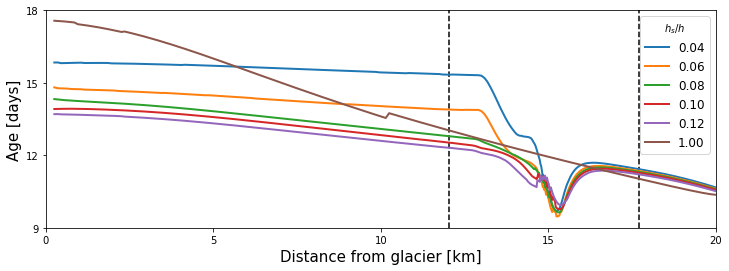

In [25]:
# Plot for layer ages
hs = np.array([1,2,3,4,5,6])
hsr = np.array([0.04,0.06,0.08,0.10,0.12,1.0])
t_idx = -1
fig3 = plt.figure(figsize=(12,4))
fig3.tight_layout()

# ax1 = fig3.add_subplot(211)
# ax1.xaxis.set_visible(False)
ax2 = fig3.add_subplot(111)

# ax1.axvline(x=4.8, color='k',lw=1.5,ls='--')
# ax1.axvline(x=6.8, color='k',lw=1.5,ls='--')
ax2.axvline(x=x_dist[119], color='k',ls='--')
ax2.axvline(x=x_dist[234], color='k',ls='--')

# ax2.set_ylim([4, 8])
# ax2.set_xlim([0, 9])
# ax2.set_xticks([0, 3, 6, 9])

ax2.set_ylim([9, 18])
ax2.set_yticks([9, 12, 15, 18])
ax2.set_xlim([0, 20])
ax2.set_xticks([0, 5, 10, 15, 20])

#ax2.set_title(r'(b) Lower Layer', loc='left', size=15)
ax2.set_ylabel('Age [days]', size=15)
ax2.set_xlabel('Distance from glacier [km]', size=15)


for i in range(len(hs)):
    age1, age2 = layer_age(hs[i],t_idx)
    #ax1.plot(x_dist, age1, lw=2, label="{:.2f}".format(hsr[i]))
    #ax1.legend(title=r'$h_s/h$', loc='best', fontsize=12)
    ax2.plot(x_dist, age2, lw=2, label="{:.2f}".format(hsr[i]))
    ax2.legend(title=r'$h_s/h$', loc='best', fontsize=12)

plt.show()    

In [ ]:
age1, age2

In [ ]:
# Plot for fractional distribution
fig4 = plt.figure(figsize=(15,5))
fig4.tight_layout()

ax1 = fig4.add_subplot(111)
cmap = 'Spectral_r'
cm = np.linspace(0,.25,26) # Contour range


sd = 9
xrange = np.array([1,120])

td, fdis, bins, mdis = frac_dis_age(sd, xrange)

im1 = ax1.contourf(td, bins, fdis.T, cm, cmap=cmap,extend='max')
cbar1 = fig4.colorbar(im1)
#cbar1.set_ticks([0, , 7, 9])
cbar1.ax.set_title(r'Fraction', size=12)

ax1.plot(td,mdis,'k-',lw=2)

#ax1.set_facecolor('#1f77b4')

ax1.set_xlim([td[0], td[-1]])
ax1.set_ylim([0, 30])
ax1.set_ylabel(r'Mean Age [d]', size=15)
ax1.set_title(r'$h_s=$'+str(sd)+' m, $h_s/h=$'+str(sd/150), loc='center', size=15)
ax1.set_xlabel(r'Time [d]', size=15)

In [12]:
state_ini = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg250/state_001.nc')
state = state_ini.isel(X=range(1,260), Y=range(35,45), Yp1=range(35,45))

x_dist = state.X.data / 1000
depth = state.Z.data


hs = np.array([6, 5, 1])
hsr = np.array([1, 0.12, 0.04])
t = -1

Rho1, A1, C1, Age1 = tracer_age_contour(hs[0], t)
Rho2, A2, C2, Age2 = tracer_age_contour(hs[1], t)
Rho3, A3, C3, Age3 = tracer_age_contour(hs[2], t)

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [54]:
x_dist[47], x_dist[96]

(4.827714177179812, 6.84684378198635)

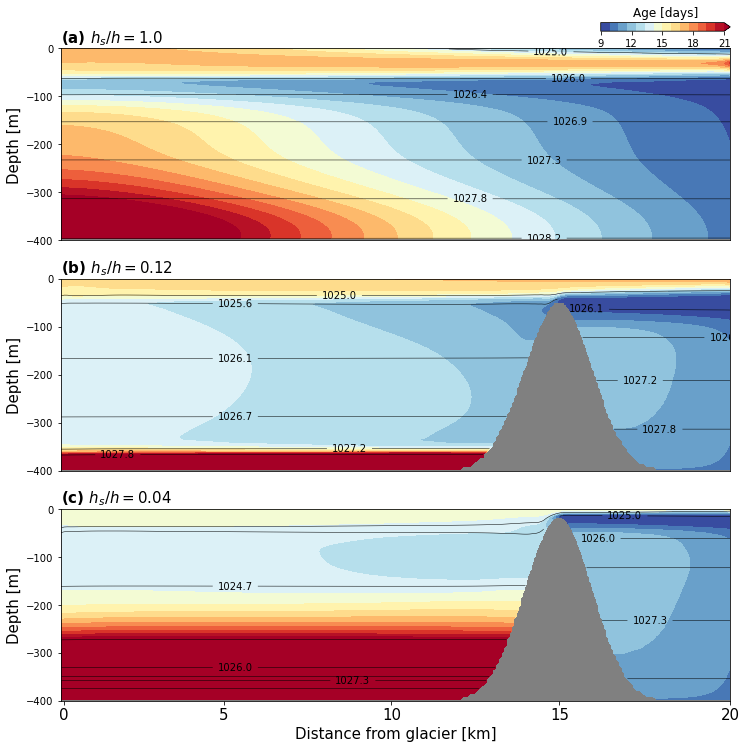

In [23]:
# Make plot for three different sill depths (New Runs)
fig5, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12))

cm = np.linspace(9,21,15) # Contour range
cmap = 'RdYlBu_r'   

im1 = ax1.contourf(x_dist, depth, Age1, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax1.set_facecolor('grey')

cbaxes = fig5.add_axes([0.75, 0.9, 0.15, 0.01])
cbar = fig5.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([9, 12, 15, 18, 21])
cbar.ax.set_title(r'Age [days]', size=12)

# cbar1 = fig5.colorbar(im1, ax=ax1)
# cbar1.ax.set_title(r'Age [d]', size=12)
cs1 = np.linspace(1015,1025,10)
cs2 = np.linspace(1026,1030,10)
CS1 = ax1.contour(x_dist, depth[:20], Rho1[:20,:], cs1, colors='black', linewidths=.5)
plt.clabel(CS1, cs1[1::2], fmt='%1.1f', fontsize=10, inline=True)

CS2 = ax1.contour(x_dist, depth[20:], Rho1[20:,:], cs2, colors='black', linewidths=.5)
plt.clabel(CS2, cs2[:], fmt='%1.1f', fontsize=10, inline=True)
ax1.xaxis.set_visible(False)
ax1.set_yticks([0, -100, -200, -300, -400])
ax1.set_ylabel('Depth [m]', size=15)
ax1.set_title(r'(a) $h_s/h=1.0$', loc='left', size=15, weight='bold')


im2 = ax2.contourf(x_dist, depth, Age2, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax2.set_facecolor('grey')

# cbar2 = fig5.colorbar(im2, ax=ax2)
# cbar2.ax.set_title(r'Age [d]', size=12)

cs3 = np.linspace(1015,1025,10)
cs4 = np.linspace(1025,1030,10)
CS3 = ax2.contour(x_dist, depth[:20], Rho2[:20,:], cs3, colors='black', linewidths=.5)
plt.clabel(CS3, cs3[1::2], fmt='%1.1f', fontsize=10, inline=True)

CS4 = ax2.contour(x_dist, depth[20:], Rho2[20:,:], cs4, colors='black', linewidths=.5)
plt.clabel(CS4, cs4[:], fmt='%1.1f', fontsize=10, inline=True)
ax2.xaxis.set_visible(False)
ax2.set_yticks([0, -100, -200, -300, -400])
ax2.set_ylabel('Depth [m]', size=15)
ax2.set_title(r'(b) $h_s/h=0.12$', loc='left', size=15, weight='bold')




im3 = ax3.contourf(x_dist, depth, Age3, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax3.set_facecolor('grey')

# cbar3 = fig5.colorbar(im3, ax=ax3)
# cbar3.ax.set_title(r'Age [d]', size=12)
cs5 = np.linspace(1014,1025,10)
cs6 = np.linspace(1024,1030,10)
CS5 = ax3.contour(x_dist, depth[:20], Rho3[:20,:], cs5, colors='black', linewidths=.5)
plt.clabel(CS5, cs5[1::2], fmt='%1.1f', fontsize=10, inline=True)

CS6 = ax3.contour(x_dist, depth[20:], Rho3[20:,:], cs6, colors='black', linewidths=.5)
plt.clabel(CS6, cs6[1::2], fmt='%1.1f', fontsize=10, inline=True)
ax3.set_yticks([0, -100, -200, -300, -400])
ax3.set_ylabel('Depth [m]', size=15)
ax3.set_title(r'(c) $h_s/h=0.04$', loc='left', size=15, weight='bold')
ax3.set_xticks([x_dist[1], 5, 10, 15, x_dist[-1]])
ax3.set_xticklabels(["0","5","10","15","20"], size=15)
ax3.set_xlabel('Distance from glacier [km]', size=15)
plt.show()

In [ ]:
# Make plot for three different sill depths
fig5, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12))

cm = np.linspace(3.5,10.5,15) # Contour range
cmap = 'RdYlBu_r'   

im1 = ax1.contourf(x_dist, depth, Age1, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax1.set_facecolor('grey')

cbaxes = fig5.add_axes([0.75, 0.9, 0.15, 0.01])
cbar = fig5.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([4, 5, 6, 7, 8, 9, 10])
cbar.ax.set_title(r'Age [days]', size=12)

# cbar1 = fig5.colorbar(im1, ax=ax1)
# cbar1.ax.set_title(r'Age [d]', size=12)
cs1 = np.linspace(1015,1025,10)
cs2 = np.linspace(1026,1030,20)
CS1 = ax1.contour(x_dist, depth[:20], Rho1[:20,:], cs1, colors='black', linewidths=.5)
plt.clabel(CS1, cs1[1::2], fmt='%1.1f', fontsize=10, inline=True)

CS2 = ax1.contour(x_dist, depth[20:], Rho1[20:,:], cs2, colors='black', linewidths=.5)
plt.clabel(CS2, cs2[:], fmt='%1.1f', fontsize=10, inline=True)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('Depth [m]', size=15)
ax1.set_title(r'(a) $h_s/h=1.0$', loc='left', size=15, weight='bold')


im2 = ax2.contourf(x_dist, depth, Age2, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax2.set_facecolor('grey')

# cbar2 = fig5.colorbar(im2, ax=ax2)
# cbar2.ax.set_title(r'Age [d]', size=12)

cs3 = np.linspace(1015,1025,10)
cs4 = np.linspace(1025,1030,20)
CS3 = ax2.contour(x_dist, depth[:20], Rho2[:20,:], cs3, colors='black', linewidths=.5)
plt.clabel(CS3, cs3[1::2], fmt='%1.1f', fontsize=10, inline=True)

CS4 = ax2.contour(x_dist, depth[20:], Rho2[20:,:], cs4, colors='black', linewidths=.5)
plt.clabel(CS4, cs4[:], fmt='%1.1f', fontsize=10, inline=True)
ax2.xaxis.set_visible(False)
ax2.set_ylabel('Depth [m]', size=15)
ax2.set_title(r'(b) $h_s/h=0.12$', loc='left', size=15, weight='bold')




im3 = ax3.contourf(x_dist, depth, Age3, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax3.set_facecolor('grey')

# cbar3 = fig5.colorbar(im3, ax=ax3)
# cbar3.ax.set_title(r'Age [d]', size=12)
cs5 = np.linspace(1016,1020,6)
cs6 = np.linspace(1020,1028,16)
CS5 = ax3.contour(x_dist, depth[:20], Rho3[:20,:], cs5, colors='black', linewidths=.5)
plt.clabel(CS5, cs5[1::2], fmt='%1.1f', fontsize=10, inline=True)

CS6 = ax3.contour(x_dist, depth[20:], Rho3[20:,:], cs6, colors='black', linewidths=.5)
plt.clabel(CS6, cs6[1::2], fmt='%1.1f', fontsize=10, inline=True)
ax3.set_ylabel('Depth [m]', size=15)
ax3.set_title(r'(c) $h_s/h=0.04$', loc='left', size=15, weight='bold')
ax3.set_xticks([x_dist[0], 3, 6, x_dist[-1]])
ax3.set_xticklabels(["0","3","6","9"], size=15)
ax3.set_xlabel('Distance from glacier [km]', size=15)
plt.show()

In [26]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/PTRACERS/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

#fig1.savefig(fig_path + '/Age_150.png', dpi=200, bbox_inches='tight')
#fig2.savefig(fig_path + '/AF_dis.png', dpi=200, bbox_inches='tight')
fig3.savefig(fig_path + '/age_layerS.png', dpi=200, bbox_inches='tight')
fig5.savefig(fig_path + '/age_dis.png', dpi=200, bbox_inches='tight')